In [18]:
!pip3 install pandas

In [19]:
!pip3 install seaborn

In [34]:
import os
import sys
import re
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

r = re.compile(r"Batch (\d+), prob = ([^\s]+)")


In [35]:
def _get_log_extension():
    return '.stderr'

In [36]:
def parse_log(log_file):
    probs = []

    with open(log_file) as f:
        last_class = None

        for l in f.readlines():
            matches = r.search(l)

            if matches:
                batch = int(matches.groups()[0])

                if last_class != batch:
                    last_class = batch
                    probs.append([])

                probs[last_class].append(float(matches.groups()[1]))

    # row x col = alignments x probabilities
    return np.asarray(probs)


In [37]:
input_folder = '/Users/emily/Desktop/EIT_Nice/Term2/sign_language_project/code/test_probabilities_loud/'
threshold = 0.9

In [38]:
log_files = sorted([i for i in os.listdir(
        input_folder) if i.endswith(_get_log_extension())])

cmap =sns.diverging_palette(5, 250, as_cmap=True)

In [39]:
log_files

['OAR.test_1_aligned_aligned_01-M-01-C-comp.5706163.stderr',
 'OAR.test_1_aligned_aligned_02-M-01-C-comp.5706164.stderr',
 'OAR.test_1_aligned_aligned_03-M-02-C-comp.5706171.stderr',
 'OAR.test_1_aligned_aligned_06-M-02-C-comp.5706172.stderr',
 'OAR.test_1_aligned_aligned_08-M-01-D-comp.5706165.stderr',
 'OAR.test_1_aligned_aligned_09-M-01-D-comp.5706166.stderr',
 'OAR.test_1_aligned_aligned_09-M-02-C-comp.5706173.stderr',
 'OAR.test_1_aligned_aligned_10-M-02-D-comp.5706174.stderr',
 'OAR.test_1_aligned_aligned_11-M-02-C-comp.5706175.stderr',
 'OAR.test_1_aligned_aligned_11-M-02-D-comp.5706176.stderr',
 'OAR.test_1_aligned_aligned_13-M-01-C-comp.5706167.stderr']

Parsing: OAR.test_1_aligned_aligned_01-M-01-C-comp.5706163.stderr
	Index: 0
	Class: 1
Probability: 0.999628

Parsing: OAR.test_1_aligned_aligned_02-M-01-C-comp.5706164.stderr
	Index: 0
	Class: 1
Probability: 0.977741

Parsing: OAR.test_1_aligned_aligned_03-M-02-C-comp.5706171.stderr
	Index: 12
	Class: 13
Probability: 0.99984

Parsing: OAR.test_1_aligned_aligned_06-M-02-C-comp.5706172.stderr
	Index: 0
	Class: 1
Probability: 0.999995

Parsing: OAR.test_1_aligned_aligned_08-M-01-D-comp.5706165.stderr
	Index: 0
	Class: 1
Probability: 0.999751

Parsing: OAR.test_1_aligned_aligned_09-M-01-D-comp.5706166.stderr
	Index: 0
	Class: 1
Probability: 0.999982

Parsing: OAR.test_1_aligned_aligned_09-M-02-C-comp.5706173.stderr
	Index: 1
	Class: 2
Probability: 0.999215

Parsing: OAR.test_1_aligned_aligned_10-M-02-D-comp.5706174.stderr
	Index: 3
	Class: 4
Probability: 0.999789

Parsing: OAR.test_1_aligned_aligned_11-M-02-C-comp.5706175.stderr
	Index: 6
	Class: 7
Probability: 0.998433

Parsing: OAR.test_

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


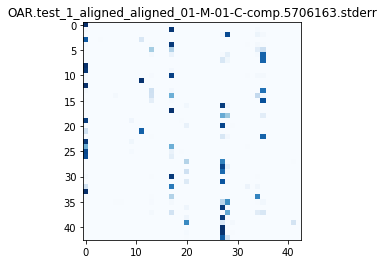

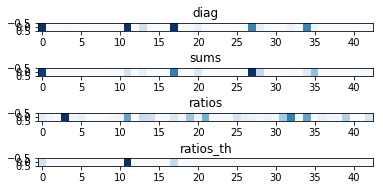

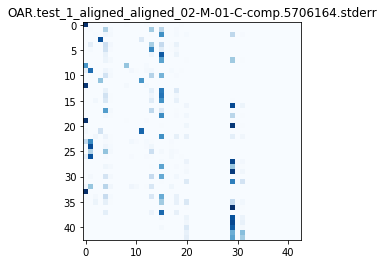

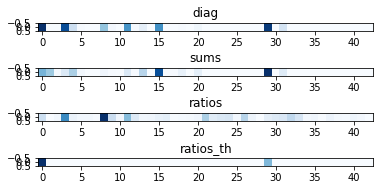

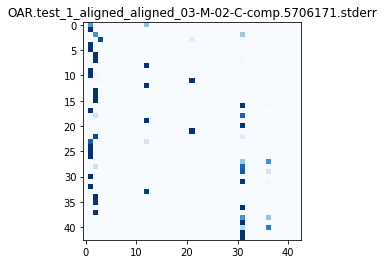

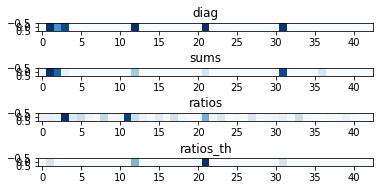

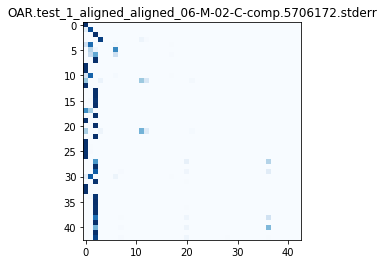

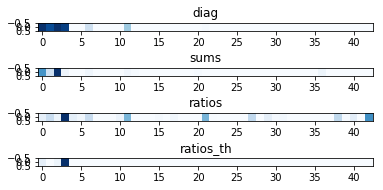

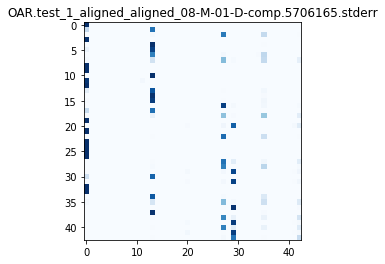

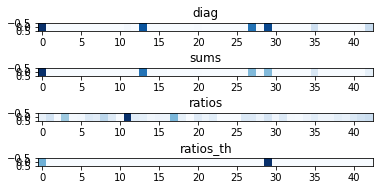

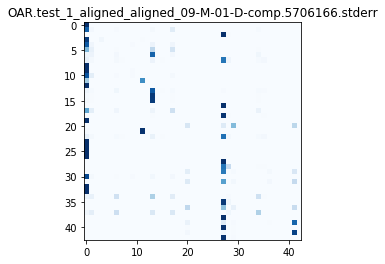

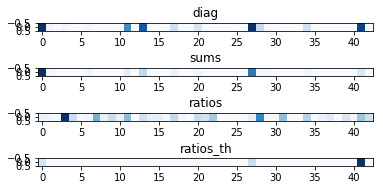

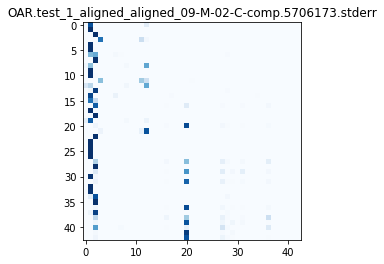

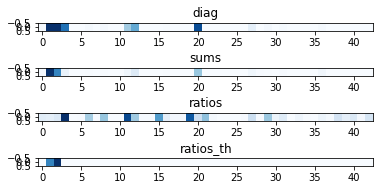

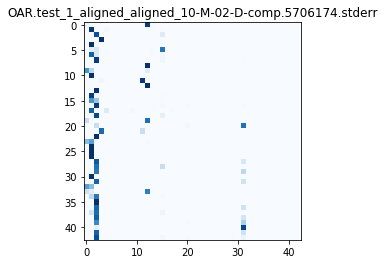

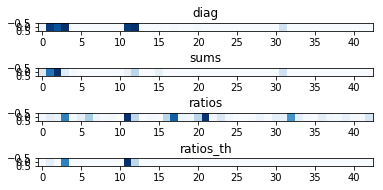

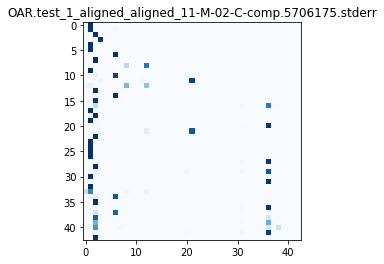

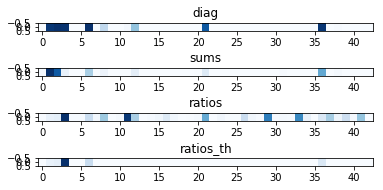

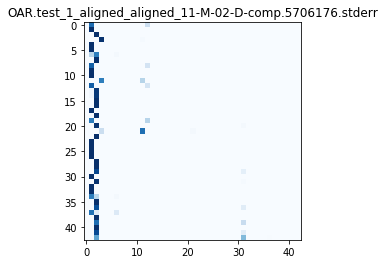

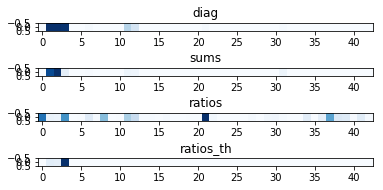

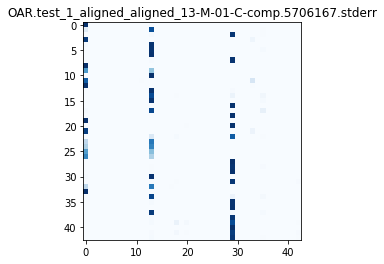

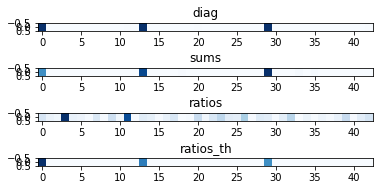

In [40]:
columns_df_wrong_class = ['log file', 'signer', 'real class', 'prob real', 'pred class', 'prob pred']
columns_df_correct_class = ['log file', 'signer', 'real class', 'prob real']
dfs = []

df_wrongly_classified = pd.DataFrame(columns=columns_df_wrong_class)
df_correct_classified = pd.DataFrame(columns=columns_df_correct_class)
for log_file in log_files:
    print("Parsing:", log_file)
    m = parse_log(os.path.join(input_folder, log_file))
    diag = m.diagonal()
    y_pred = np.argmax(diag)
    
    print('\tIndex:', y_pred)
    print('\tClass:', y_pred + 1)
    print('Probability:', diag[y_pred])
    print("")
    
    real_class = re.search("-([0-9]+)\-", log_file).group(1)
    if int(real_class) != y_pred + 1:
        signer = re.search("_([0-9]+)-", log_file).group(1)
        new = pd.DataFrame([[log_file, signer, real_class, diag[int(real_class)-1], (y_pred + 1), diag[y_pred]]], columns=columns_df_wrong_class)
        df_wrongly_classified = df_wrongly_classified.append(new, ignore_index=True)
    else:
        new = pd.DataFrame([[log_file, diag[y_pred], (y_pred + 1), diag[y_pred]]], columns=columns_df_correct_class)
        df_correct_classified = df_correct_classified.append(new, ignore_index=True)
        
    
    sums = np.apply_along_axis(np.sum, 0, m)
    ratios = diag / sums
    ratios_th = ratios.copy()
    ratios_th[diag < threshold] = 0
    y_pred = np.argmax(ratios_th)

    plt.figure()
    plt.title(log_file)
    plt.imshow(m, interpolation='none', cmap='Blues')

    plt.figure()
    plt.subplot(511)
    plt.title("diag")
    plt.imshow(diag.reshape((1, 43)), interpolation='none', cmap='Blues')

    plt.subplot(512)
    plt.title("sums")
    plt.imshow(sums.reshape((1, 43)), interpolation='none', cmap='Blues')

    plt.subplot(513)
    plt.title("ratios")
    plt.imshow(ratios.reshape((1, 43)), interpolation='none', cmap='Blues')

    plt.subplot(514)
    plt.title("ratios_th")
    plt.imshow(ratios_th.reshape((1, 43)),
               interpolation='none', cmap='Blues')
    
    df = pd.DataFrame(m)
    dfs.append(df)


In [41]:
# Correct classifications
df_correct_classified

,log file,signer,real class,prob real
0,OAR.test_1_aligned_aligned_01-M-01-C-comp.5706...,0.999628,1,0.999628
1,OAR.test_1_aligned_aligned_02-M-01-C-comp.5706...,0.977741,1,0.977741
2,OAR.test_1_aligned_aligned_08-M-01-D-comp.5706...,0.999751,1,0.999751
3,OAR.test_1_aligned_aligned_09-M-01-D-comp.5706...,0.999982,1,0.999982
4,OAR.test_1_aligned_aligned_09-M-02-C-comp.5706...,0.999215,2,0.999215
5,OAR.test_1_aligned_aligned_13-M-01-C-comp.5706...,0.990485,1,0.990485


In [42]:
# wrong classifications
df_wrongly_classified

,log file,signer,real class,prob real,pred class,prob pred
0,OAR.test_1_aligned_aligned_03-M-02-C-comp.5706...,03,02,0.996764,13,0.999840
1,OAR.test_1_aligned_aligned_06-M-02-C-comp.5706...,06,02,0.891980,1,0.999995
2,OAR.test_1_aligned_aligned_10-M-02-D-comp.5706...,10,02,0.959356,4,0.999789
3,OAR.test_1_aligned_aligned_11-M-02-C-comp.5706...,11,02,0.968649,7,0.998433
4,OAR.test_1_aligned_aligned_11-M-02-D-comp.5706...,11,02,0.999777,3,0.999985


In [29]:
i = 0
print(log_files[i])
m = parse_log(os.path.join(input_folder, log_files[i]))
df = pd.DataFrame(m)
df.round(3).style.background_gradient(cmap, low=0, high=1)

OAR.test_1_aligned_aligned_01-M-01-C-comp.5706163.stderr


In [30]:
i = 1
print(log_files[i])
m = parse_log(os.path.join(input_folder, log_files[i]))
df = pd.DataFrame(m)
df.round(3).style.background_gradient(cmap, low=0, high=1)

OAR.test_1_aligned_aligned_02-M-01-C-comp.5706164.stderr


In [31]:
i = 2
print(log_files[i])
m = parse_log(os.path.join(input_folder, log_files[i]))
df = pd.DataFrame(m)
df.round(3).style.background_gradient(cmap, low=0, high=1)

OAR.test_1_aligned_aligned_08-M-01-D-comp.5706165.stderr


In [32]:
i = 3
print(log_files[i])
m = parse_log(os.path.join(input_folder, log_files[i]))
df = pd.DataFrame(m)
df.round(3).style.background_gradient(cmap, low=0, high=1)

OAR.test_1_aligned_aligned_09-M-01-D-comp.5706166.stderr


In [33]:
i = 4
print(log_files[i])
m = parse_log(os.path.join(input_folder, log_files[i]))
df = pd.DataFrame(m)
df.round(3).style.background_gradient(cmap, low=0, high=1)

OAR.test_1_aligned_aligned_13-M-01-C-comp.5706167.stderr
